<h1>Regressionsprobleme mit Neuronalen Netzen</h1><br>
Hier warten nun ganz andere Probleme, z.B. unterschiedliche Skalierung der Inputvariablen.<br><br><b>Der Boston Housing Price-Datensatz</b><br>
Dieser ist recht klein, 506 Beobachtungen, wobei jedes Feature eine andere Skalierung hat. Die Ziele sind die die Medianwerte der Häuser in Tsd. Dollar.

In [35]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape) # 404 Beobachtungen mit 13 Variablen
print(train_data[28], '\n',train_targets[28])

(404, 13)
[  0.67191   0.        8.14      0.        0.538     5.813    90.3
   4.682     4.      307.       21.      376.88     14.81   ] 
 16.6


Die Daten müssen bei unterschiedlicher Skalierung nicht präpariert werden, indem sie One-Hot-kodiert werden. Hier müssen sie normalisiert werden. Wie bei der Hauptkomponentenanalyse. Dafür gibt es in np-Arrays eingebaute Methoden, die mithilfe von axis = 0 die Statistiken für das jeweilige Feature/die jeweilige Variable finden.

In [36]:
print(train_data.mean(axis = 0))
print(train_data[28])

means = train_data.mean(axis = 0)
std_deviations = train_data.std(axis = 0)
train_data -= means
train_data /= std_deviations

print(train_data[28])

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
[  0.67191   0.        8.14      0.        0.538     5.813    90.3
   4.682     4.      307.       21.      376.88     14.81   ]
[-0.3329834  -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.64053626
  0.76289357  0.4644321  -0.62624905 -0.59517003  1.14850044  0.23508618
  0.28557943]


Ein Problem mit kleinen Datensätzen wie diesem hier, dass sie leicht zum Overfitting führen. Um dem etwas entgegenzusetzen, werden relativ kleine Netze verwendet. Das sollte verhindern, dass sich ein zu großes Netz auf die nicht-generalisierbaren Eigenheiten der Trainingsdaten einpendeln.

In [37]:
from keras import models
from keras import layers

def build_model():
    # will have multiple instances, that's why we use a function
    model = models.Sequential()
    model.add(layers.Dense(
        64, activation = 'relu', 
        input_shape = (train_data.shape[1], )
    ))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    
    model.compile(
        optimizer = 'rmsprop',
        loss = 'mse',
        metrics = ['mae']
    )
    
    return model

Die letzte Schicht endet mit einem einzelnen Neuron und ohne Aktivierungsfunktion, ist also linear, da uns ja der uneingeschränkte Outputwert, also der vorausgesagte Wert des Hauses, interessiert. Würdest du z.B. die Sigmoid über das letzte Neuron legen, würden die linearen Werten auf [0,1] abgebildet werden. Ist nicht unser Ziel. Die Loss Function ist nun der MSE, Mean Squared Error, die quadrierte Differenz zwischen dem Ziel und dem vorausgesagten Wert. Der beobachtete Kennwert ist MAE, mean absolute error, also der nicht-quadrierte MSE, einfach nur die Abweichung Ziel <=> Voraussage.

<b>K-Fold-Validation</b><br><br>
Wenn Datensätze bereits klein sind, kann ein weiteres Aussieben der Validierungsdaten dem Modell nur schaden, weil das Ergebnis sehr davon abhängig ist, welche wenige Datenpunkte noch über sind.<br>
Darum wird diese Technik genutzt. Die Daten werden in k Teile partitioniert. Es werden k Modelle trainiert auf k - 1 Teilen, wobei 1 Teil der Validierung dient.

In [38]:
import numpy as np

k = 4
print(int(len(train_data) / k))
num_val_samples = int(len(train_data) / k)
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold ' + str(i + 1) + '.')
    # Daten, von : bis
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],      # alles vor Validierungsdaten
        train_data[(i + 1) * num_val_samples:] # alles nach Validierungsdaten
    ], axis = 0)
    
    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],      # alles vor Validierungsdaten
        train_targets[(i + 1) * num_val_samples:] # alles nach Validierungsdaten
    ], axis = 0)
    
    print(len(partial_train_data), len(val_data))
    
    model = build_model()
    model.fit(
        np.array(partial_train_data),
        np.array(partial_train_targets),
        epochs = num_epochs,
        batch_size = 1,
        verbose = 0
    )
    
    (mse, mae) = model.evaluate(x = val_data, y = val_targets, verbose = 0)
    print('MAE:', mae)
    all_scores.append(mae)
    

101
Processing fold 1.
303 101
Processing fold 2.
303 101
Processing fold 3.
303 101
Processing fold 4.
303 101


In [39]:
print(all_scores, np.mean(all_scores))
# Ein MAE von 2.42 bedeutet, dass durchschnittlich noch $2400 Fehler existiert,
# was viel ist bei Preisen von
print(
    '$' + str(int(min(train_targets)) * 1000), 
    'bis',
    '$' + str(int(max(train_targets))* 1000)
)

[2.063244300313515, 2.2822579416898217, 2.947527550234653, 2.378170597671282] 2.417800097477318
$5000 bis $50000


Nun optimieren wir die Schleife ein wenig. Zum einen lassen wir sie nun 500 Epochen laufen, also 500 Durchläufe durch die Trainingsdaten: 500 Mal mit jeder Aufteilung Validierung/Trainigsdaten. Wir wollen uns nun aber anschauen, wann der Fehler für die Validierungsdaten in Abhängigkeit von der aktuellen Epoche minimiert wird.

In [40]:
k = 4
num_val_samples = int(len(train_data) / k)
num_epochs = 1500
all_mae_hists = []

for i in range(k):
    print('Processing fold ' + str(i + 1) + '.')
    # Daten, von : bis
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],      # alles vor Validierungsdaten
        train_data[(i + 1) * num_val_samples:] # alles nach Validierungsdaten
    ], axis = 0)
    
    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],      # alles vor Validierungsdaten
        train_targets[(i + 1) * num_val_samples:] # alles nach Validierungsdaten
    ], axis = 0)
    
    print(len(partial_train_data), len(val_data))
    
    model = build_model()
    hist = model.fit(
        np.array(partial_train_data),
        np.array(partial_train_targets),
        epochs = num_epochs,
        batch_size = 1,
        verbose = 0
    )
    
    all_mae_hists.append(hist.history)

Processing fold 1.
303 101
Processing fold 2.
303 101
Processing fold 3.
303 101
Processing fold 4.
303 101


In [41]:
print(len(all_mae_hists))
print(all_mae_hists[0].keys())
mae_means = [all_mae_hists[i]['mean_absolute_error'] for i in range(len(all_mae_hists))]
print(len(mae_means), len(mae_means[0]))
# also 4 Folds, mit je dem MAE der 300 Epochen
# Wir bilden den Durchschnitt der 4 Folds über die 300 Epochen

mae_fold_means = [
    np.mean([mae[i] for mae in mae_means]) 
    for i in range(num_epochs)
]

4
dict_keys(['loss', 'mean_absolute_error'])
4 1500


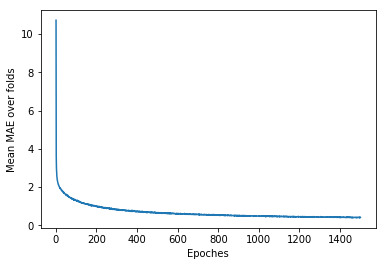

In [42]:
# nun machen wir Plots daraus
import matplotlib.pyplot as plot

plot.plot(range(1, len(mae_fold_means) + 1), mae_fold_means)
plot.xlabel('Epoches')
plot.ylabel('Mean MAE over folds')
plot.show()

# villeicht ist das die MAE für Traniningsdaten?